In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

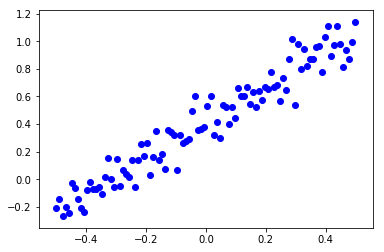

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [3]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[-0.04496457]])
b: variable b([ 0.])
Operations on chainer.Variable: variable([[ 122.95503235]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[-0.04496457]] [[ 122.95503235]]


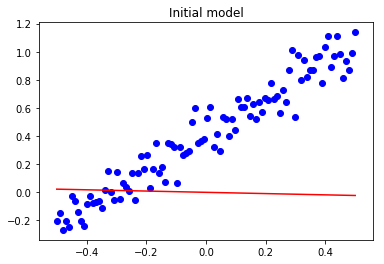

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [5]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.3275081217288971)
dloss/dW [[-0.22476175]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.30157068371772766)
Itr 25 loss: variable(0.010271136648952961)
Itr 50 loss: variable(0.009708966128528118)
Itr 75 loss: variable(0.009706376120448112)


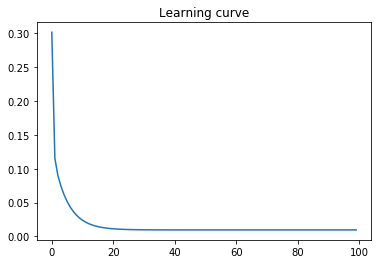

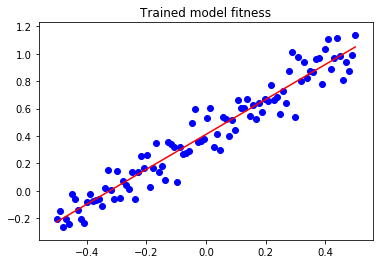

In [6]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []
learning_rate = .6

for i in range(100):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    
    loss.backward()
    model.W.data[:] -= learning_rate * model.W.grad
    model.b.data[:] -= learning_rate * model.b.grad
    
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

len-train=60000  type-train=<class 'chainer.datasets.tuple_dataset.TupleDataset'>
len-test=10000  type-test=<class 'chainer.datasets.tuple_dataset.TupleDataset'>
train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


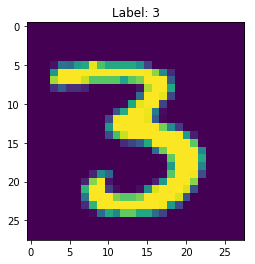

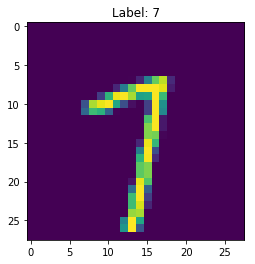

In [7]:
train, test = chainer.datasets.get_mnist()
print("len-train={}  type-train={}".format(len(train), type(train)))
print("len-test={}  type-test={}".format(len(test), type(test)))
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [8]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("ep: {}; itr: {}; ".format(epoch, itr) + "; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

ep: 0; itr: 0; loss: 2.40678262711; accuracy: 0.0
ep: 0; itr: 300; loss: 0.569433676004; accuracy: 0.8725
ep: 0; itr: 600; loss: 0.476313342452; accuracy: 0.8775
ep: 0; itr: 900; loss: 0.388053823113; accuracy: 0.895
ep: 0; itr: 1200; loss: 0.354697887599; accuracy: 0.9025
ep: 0; itr: 1500; loss: 0.335270907283; accuracy: 0.9075
ep: 0; itr: 1800; loss: 0.423562815487; accuracy: 0.8825
ep: 0; itr: 2100; loss: 0.261588849127; accuracy: 0.93
ep: 0; itr: 2400; loss: 0.353349348307; accuracy: 0.8975
ep: 0; itr: 2700; loss: 0.300362788439; accuracy: 0.9025
ep: 0; itr: 3000; loss: 0.276302228868; accuracy: 0.935
ep: 0; itr: 3300; loss: 0.293873334825; accuracy: 0.91
ep: 0; itr: 3600; loss: 0.273738875985; accuracy: 0.93
ep: 1; itr: 0; loss: 0.211638440192; accuracy: 0.9325
ep: 1; itr: 300; loss: 0.34065794602; accuracy: 0.9025
ep: 1; itr: 600; loss: 0.243211871684; accuracy: 0.93
ep: 1; itr: 900; loss: 0.443855938315; accuracy: 0.895
ep: 1; itr: 1200; loss: 0.276076661348; accuracy: 0.9175
ep

Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [9]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        
        logits_1 = self.l1(x)
        n1 = F.rrelu(logits_1)
        
        logits_2 = self.l2(n1)
        n2 = F.rrelu(logits_2)
        
        logits_3 = self.l3(n2)
        
        return logits_3
        
run(MLP(200, 10))

ep: 0; itr: 0; loss: 2.32113289833; accuracy: 0.0625
ep: 0; itr: 300; loss: 0.376372954249; accuracy: 0.8725
ep: 0; itr: 600; loss: 0.298839640617; accuracy: 0.905
ep: 0; itr: 900; loss: 0.29812705636; accuracy: 0.925
ep: 0; itr: 1200; loss: 0.188545182347; accuracy: 0.925
ep: 0; itr: 1500; loss: 0.198846592307; accuracy: 0.9475
ep: 0; itr: 1800; loss: 0.231510849595; accuracy: 0.93
ep: 0; itr: 2100; loss: 0.136716237068; accuracy: 0.95
ep: 0; itr: 2400; loss: 0.132185168862; accuracy: 0.9525
ep: 0; itr: 2700; loss: 0.105401139855; accuracy: 0.975
ep: 0; itr: 3000; loss: 0.191492304802; accuracy: 0.9375
ep: 0; itr: 3300; loss: 0.195574881434; accuracy: 0.9325
ep: 0; itr: 3600; loss: 0.140146896243; accuracy: 0.9675
ep: 1; itr: 0; loss: 0.111413996816; accuracy: 0.9725
ep: 1; itr: 300; loss: 0.0976139241457; accuracy: 0.9725
ep: 1; itr: 600; loss: 0.120990692973; accuracy: 0.955
ep: 1; itr: 900; loss: 0.161520197988; accuracy: 0.96
ep: 1; itr: 1200; loss: 0.0887267488241; accuracy: 0.96

Next you should try to implement logging test loss and see if the model is overfitting.

In [10]:
def better_run(model, batchsize=16, num_epochs=2, optimizer=chainer.optimizers.Adam(eta=0.60)):

    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                
                xt = np.concatenate([datum[0][None, :] for datum in test])
                yt = np.array([datum[1] for datum in test])
                logits_t = model(xt)
                stats["test_accuracy"] = F.accuracy(logits_t, yt).data
                stats["test_loss"] = F.softmax_cross_entropy(logits_t, yt).data
                
                print("ep: {}; itr: {}; ".format(epoch, itr) + "; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

optimizer = chainer.optimizers.Adam(eta=0.60) # we will use chainer's Adam implementation instead of writing our own gradient based optimization
better_run(MLP(200, 10), optimizer=optimizer)

ep: 0; itr: 0; loss: 2.33953475952; accuracy: 0.0; test_accuracy: 0.1324; test_loss: 2.30768
ep: 0; itr: 300; loss: 0.414294537306; accuracy: 0.8725; test_accuracy: 0.9044; test_loss: 0.34005
ep: 0; itr: 600; loss: 0.345464431643; accuracy: 0.91; test_accuracy: 0.9208; test_loss: 0.273618
ep: 0; itr: 900; loss: 0.385762937665; accuracy: 0.9025; test_accuracy: 0.9232; test_loss: 0.252396
ep: 0; itr: 1200; loss: 0.213527238369; accuracy: 0.9325; test_accuracy: 0.9335; test_loss: 0.21802
ep: 0; itr: 1500; loss: 0.323114873171; accuracy: 0.9125; test_accuracy: 0.9405; test_loss: 0.195472
ep: 0; itr: 1800; loss: 0.173973903656; accuracy: 0.935; test_accuracy: 0.9432; test_loss: 0.191207
ep: 0; itr: 2100; loss: 0.110739498138; accuracy: 0.96; test_accuracy: 0.9501; test_loss: 0.159279
ep: 0; itr: 2400; loss: 0.222223940492; accuracy: 0.945; test_accuracy: 0.9542; test_loss: 0.148561
ep: 0; itr: 2700; loss: 0.133428604007; accuracy: 0.965; test_accuracy: 0.9586; test_loss: 0.135349
ep: 0; itr

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc

In [11]:
class ConvNN(chainer.Chain):
    
    # conv - relu - 2x2 max pool - affine - relu - affine - softmax

    def __init__(self, n_units, n_out):
        super(ConvNN, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Convolution2D(
                in_channels=1, out_channels=30, ksize=10, stride=2)
            self.l2 = L.Linear(None, 800)  # n_units -> n_units
            self.l3 = L.Linear(None, 10)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        
        #print("x.shape={}".format(x.shape))
        x=x.reshape(x.shape[0],1,28,28)
        logits_1 = self.l1(x)
        n1a = F.rrelu(logits_1)
        n1b = F.max_pooling_2d(n1a, ksize=2, stride=2)
        
        logits_2 = self.l2(n1b)
        n2 = F.rrelu(logits_2)
        
        logits_3 = self.l3(n2)
        #print("logits_3.shape={}".format(logits_3.shape))
        
        return logits_3

optimizer = chainer.optimizers.Adam(beta1=.9, beta2=.9, eta=0.10, weight_decay_rate=.999)
better_run(ConvNN(200, 10))

ep: 0; itr: 0; loss: 2.43061590195; accuracy: 0.0; test_accuracy: 0.1249; test_loss: 2.52814
ep: 0; itr: 300; loss: 0.215568059087; accuracy: 0.93; test_accuracy: 0.9388; test_loss: 0.197971
ep: 0; itr: 600; loss: 0.194230608344; accuracy: 0.945; test_accuracy: 0.9602; test_loss: 0.131503
ep: 0; itr: 900; loss: 0.151482195854; accuracy: 0.9525; test_accuracy: 0.968; test_loss: 0.102281
ep: 0; itr: 1200; loss: 0.0734516203403; accuracy: 0.98; test_accuracy: 0.9721; test_loss: 0.0869171
ep: 0; itr: 1500; loss: 0.0957808887959; accuracy: 0.9725; test_accuracy: 0.965; test_loss: 0.105164
ep: 0; itr: 1800; loss: 0.0640955525637; accuracy: 0.985; test_accuracy: 0.9779; test_loss: 0.0722716
ep: 0; itr: 2100; loss: 0.075143853426; accuracy: 0.9825; test_accuracy: 0.9748; test_loss: 0.0820559
ep: 0; itr: 2400; loss: 0.0656267571449; accuracy: 0.98; test_accuracy: 0.9818; test_loss: 0.0541739
ep: 0; itr: 2700; loss: 0.0751827687025; accuracy: 0.9725; test_accuracy: 0.9828; test_loss: 0.0495945
e

In [12]:
class LeNet5(chainer.Chain):
    def __init__(self):
        super(LeNet5, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=6, ksize=5, stride=1)
            self.conv2 = L.Convolution2D(
                in_channels=6, out_channels=16, ksize=5, stride=1)
            self.conv3 = L.Convolution2D(
                in_channels=16, out_channels=120, ksize=4, stride=1)
            self.fc4 = L.Linear(None, 484)
            self.fc5 = L.Linear(484, 10)

    def __call__(self, x):
        x=x.reshape(x.shape[0],1,28,28)
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.relu(self.conv3(h))
        h = F.relu(self.fc4(h))
        if chainer.config.train:
            return self.fc5(h)
        return F.softmax(self.fc5(h))

better_run(LeNet5())

ep: 0; itr: 0; loss: 2.28599691391; accuracy: 0.1875; test_accuracy: 0.1592; test_loss: 2.30353
ep: 0; itr: 300; loss: 0.311914050579; accuracy: 0.905; test_accuracy: 0.932; test_loss: 0.223771
ep: 0; itr: 600; loss: 0.168188151419; accuracy: 0.9425; test_accuracy: 0.9534; test_loss: 0.1549
ep: 0; itr: 900; loss: 0.167963538766; accuracy: 0.96; test_accuracy: 0.9546; test_loss: 0.140753
ep: 0; itr: 1200; loss: 0.104698985815; accuracy: 0.965; test_accuracy: 0.9659; test_loss: 0.10854
ep: 0; itr: 1500; loss: 0.0654561585188; accuracy: 0.9775; test_accuracy: 0.9696; test_loss: 0.100044
ep: 0; itr: 1800; loss: 0.0779303359985; accuracy: 0.98; test_accuracy: 0.9693; test_loss: 0.0970106
ep: 0; itr: 2100; loss: 0.0721018698812; accuracy: 0.975; test_accuracy: 0.9751; test_loss: 0.0804999
ep: 0; itr: 2400; loss: 0.133920491338; accuracy: 0.9575; test_accuracy: 0.9726; test_loss: 0.0873263
ep: 0; itr: 2700; loss: 0.0566477233171; accuracy: 0.9775; test_accuracy: 0.9767; test_loss: 0.0734472
e